In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
data = pd.read_csv(r"C:\Users\Mahsa\Desktop\base\energy poverty\Residential total final consumption (TFC) by source - Islamic Republic of Iran.csv",
                   skiprows=3)
data.rename(columns={
    "Unnamed: 0" : "year"
}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                33 non-null     int64  
 1   Oil products        33 non-null     int64  
 2   Natural gas         33 non-null     int64  
 3   Biofuels and waste  33 non-null     int64  
 4   Electricity         33 non-null     int64  
 5   Coal                30 non-null     float64
 6   Units               33 non-null     object 
dtypes: float64(1), int64(5), object(1)
memory usage: 1.9+ KB


In [19]:
data.head()

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
0,1990,350837,109286,3526,62438,NaN,TJ
1,1991,369349,157915,3777,68860,NaN,TJ
2,1992,425104,245763,4402,70232,NaN,TJ
3,1993,407478,269018,4928,79714,774.0,TJ
4,1994,490043,343683,5500,80902,774.0,TJ


In [20]:
data.columns

Index(['year', 'Oil products', 'Natural gas', 'Biofuels and waste',
       'Electricity', 'Coal', 'Units'],
      dtype='object')

In [4]:
data.dropna(inplace = True)

In [5]:
cols = ['Oil products', 'Natural gas', 'Biofuels and waste', 'Electricity', 'Coal']

# Calculate row totals for just these columns
row_totals = data[cols].sum(axis=1)

# Divide each column by the row total
data[cols] = (data[cols].div(row_totals, axis=0))*100

In [23]:
data.head()

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
3,1993,53.480979,35.308277,0.646794,10.462363,0.101587,TJ
4,1994,53.213371,37.320258,0.597241,8.785082,0.084048,TJ
5,1995,50.411096,40.354146,0.539800,8.615708,0.079250,TJ
6,1996,47.381638,43.665891,0.538724,8.339021,0.074726,TJ
7,1997,44.751484,46.106714,0.423696,8.648003,0.070103,TJ


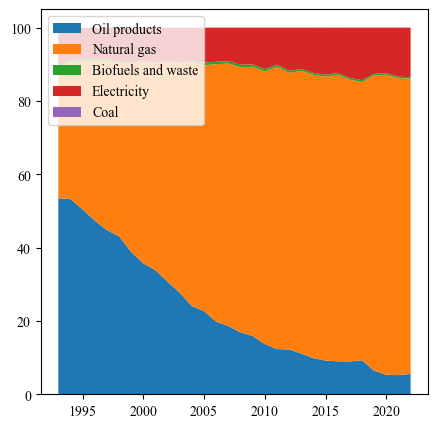

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.stackplot(data["year"], data[cols].T, labels=cols)

ax.legend(loc='upper left')
plt.show()

In [33]:
data.loc[data["year"]==2022]

,year,Oil products,Natural gas,Biofuels and waste,Electricity,Coal,Units
32,2022,5.552253,80.499857,0.40398,13.530631,0.013278,TJ


# Working on HIES

In [2]:
data = pd.read_pickle("merged")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582542 entries, 0 to 582542
Columns: 113 entries, HHID to energy_Ratio
dtypes: float64(98), object(15)
memory usage: 506.7+ MB


In [3]:
iran_provinces = {
    "آذربایجان شرقی": "East Azerbaijan",
    "آذربایجان غربی": "West Azerbaijan",
    "اردبیل": "Ardabil",
    "اصفهان": "Esfahan",
    "البرز": "Alborz",
    "ایلام": "Ilam",
    "بوشهر": "Bushehr",
    "تهران": "Tehran",
    "خراسان جنوبی": "South Khorasan",
    "خراسان رضوی": "Razavi Khorasan",
    "خراسان شمالی": "North Khorasan",
    "خوزستان": "Khuzestan",
    "زنجان": "Zanjan",
    "سمنان": "Semnan",
    "سیستان و بلوچستان": "Sistan and Baluchestan",
    "فارس": "Fars",
    "قزوین": "Qazvin",
    "قم": "Qom",
    "كردستان": "Kurdistan",
    "كرمان": "Kerman",
    "كهگیلویه و بویراحمد": "Kohgiluyeh and Boyer-Ahmad",
    "لرستان": "Lorestan",
    "مازندران": "Mazandaran",
    "مرکزی": "Markazi",
    "هرمزگان": "Hormozgan",
    "همدان": "Hamadan",
    "چهارمحال و بختیاری": "Chaharmahal and Bakhtiari",
    "کرمانشاه": "Kermanshah",
    "گلستان": "Golestan",
    "گیلان": "Gilan",
    "یزد": "Yazd"
}
data["province"] = data["province"].map(iran_provinces)

In [4]:
def weighted_describe(values, weights):
    values = np.asarray(values)
    weights = np.asarray(weights)

    # Drop NaNs
    mask = ~np.isnan(values)
    values = values[mask]
    weights = weights[mask]

    # Weighted count
    count = weights.sum()

    # Weighted mean
    mean = np.average(values, weights=weights)

    # Weighted variance and std
    variance = np.average((values - mean) ** 2, weights=weights)
    std = np.sqrt(variance)

    # Weighted min and max
    min_val = values.min()
    max_val = values.max()

    # Weighted percentiles
    def weighted_percentile(data, weights, percent):
        """Compute weighted percentile (percent between 0-100)."""
        sorter = np.argsort(data)
        data, weights = data[sorter], weights[sorter]
        cdf = np.cumsum(weights) / weights.sum()
        return np.interp(percent / 100, cdf, data)

    q25 = weighted_percentile(values, weights, 25)
    q50 = weighted_percentile(values, weights, 50)  # median
    q75 = weighted_percentile(values, weights, 75)

    return pd.Series({
        "count": count,
        "mean": mean,
        "std": std,
        "min": min_val,
        "25%": q25,
        "50%": q50,
        "75%": q75,
        "max": max_val
    })


In [5]:
df = data.loc[(data["Tenure"]=="Rented")&(data["year"]==1402)&(data["region"]=="Urban")]
df["HouseExpRatio"] = 100*((df["RentExp"]+df["EstRentExp"])/df["all_expenditure"])
weighted_describe(df["HouseExpRatio"], weights= df["weight"])

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_8012\1825656094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HouseExpRatio"] = 100*((df["RentExp"]+df["EstRentExp"])/df["all_expenditure"])


count    3.353776e+06
mean     3.194073e+01
std      1.230234e+01
min      1.000032e+00
25%      2.393064e+01
50%      3.071063e+01
75%      3.983277e+01
max      1.000000e+02
dtype: float64

In [4]:
data.isna().sum()

HHID                    0
region                  0
quarter                 0
weight               4356
county_code          1865
                    ...  
OtherEnergyReExp        0
year                    0
all_expenditure         0
all_energy_EXP          0
energy_Ratio        10780
Length: 69, dtype: int64

In [6]:
data = data.loc[data["FoodExp"]!= 0]
data.isna().sum()

HHID                    0
month              150712
household_type          0
region                  0
quarter                 0
                    ...  
OtherExtraSale          0
year                    0
all_expenditure         0
all_energy_EXP          0
energy_Ratio            0
Length: 113, dtype: int64

In [7]:
data["year"] = np.where(
    data["year"] == 1403, 2024, np.where(
        data["year"] == 1402, 2023, np.where(
            data["year"] == 1401, 2022, np.where(
                data["year"] == 1400, 2021, np.where(
                    data["year"] == 99, 2020, np.where(
                        data["year"] == 98, 2019, np.where(
                            data["year"] == 97, 2018, np.where(
                                data["year"] == 96, 2017, np.where(
                                    data["year"] == 95, 2016, np.where(
                                        data["year"] == 94, 2015, np.where(
                                            data["year"] == 93, 2014, np.where(
                                                data["year"] == 92, 2013, np.where(
                                                    data["year"] == 91, 2012, np.where(
                                                        data["year"] == 90, 2011, np.where(
                                                            data["year"] == 89, 2010, pd.NA
                                                        )
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_13884\436222094.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=data["year"].unique(), vert=False, flierprops=flierprops)


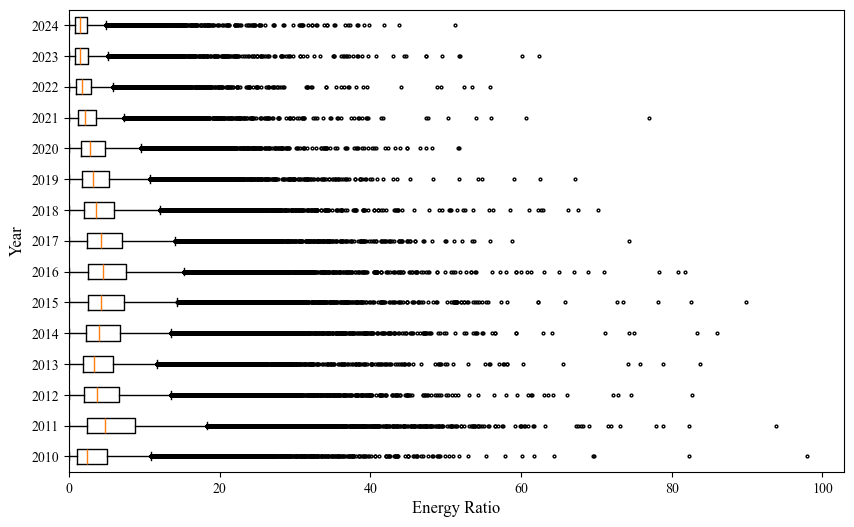

In [6]:
# Group by year
groups = [data.loc[data["year"] == y, "energy_Ratio"] for y in data["year"].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal boxplot
flierprops = dict(marker='o', markersize=2, linestyle='none')
ax.boxplot(groups, labels=data["year"].unique(), vert=False, flierprops=flierprops)

# Labels with Times New Roman font
ax.set_xlabel("Energy Ratio", fontname="Times New Roman", fontsize=12)
ax.set_ylabel("Year", fontname="Times New Roman", fontsize=12)

# Change tick labels font to Times New Roman
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname("Times New Roman")
plt.xlim(0,)
plt.show()


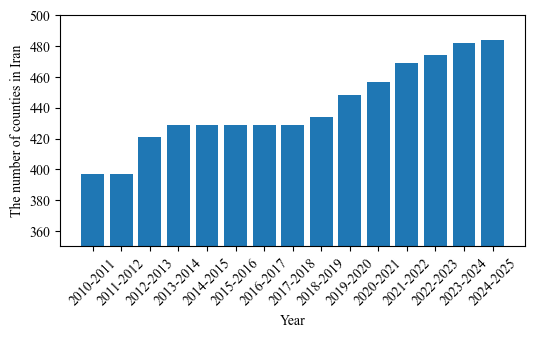

In [35]:
list_ofColumns = [
    "2010-2011",
    "2011-2012",
    "2012-2013",
    "2013-2014",
    "2014-2015",
    "2015-2016",
    "2016-2017",
    "2017-2018",
    "2018-2019",
    "2019-2020",
    "2020-2021",
    "2021-2022",
    "2022-2023",
    "2023-2024",
    "2024-2025"
]
num_counties = [
    397,397,421,429,429,429,429,429,434,448,457,469,474,482,484
]

plt.figure(figsize=(6, 3))
plt.bar(list_ofColumns, num_counties)
plt.ylim(350, 500)
plt.xticks(fontsize=10, rotation = 45)
plt.yticks(fontsize=10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("The number of counties in Iran", fontsize = 10)
plt.show()

In [13]:
for col in data.columns:
    print(f"the name of the col is {col}")
    print(data[col].unique())

the name of the col is HHID
['2000025066' '2000077193' '2000149068' ... '12707337550' '12713343553'
 '12105246550']
the name of the col is region
['Rural' 'Urban']
the name of the col is quarter
['spring' 'Summer' 'Fall' 'Winter']
the name of the col is weight
[  153.79051396   153.97073722   140.69929671 ... 13999.
 19426.         12648.        ]
the name of the col is county_code
['0001' '0006' '0010' '0005' '0007' '0011' '0004' '0009' '0003' '0002'
 '0101' '0105' '0103' '0104' '0111' '0107' '0106' '0112' '0114' '0102'
 '0116' '0108' '0109' '0115' '0110' '0113' '0221' '0214' '0207' '0201'
 '0218' '0219' '0202' '0205' '0220' '0210' '0215' '0216' '0204' '0208'
 '0206' '0222' '0307' '0313' '0316' '0311' '0325' '0305' '0302' '0310'
 '0320' '0312' '0303' '0324' '0314' '0322' '0306' '0315' '0323' '0321'
 '0319' '0402' '0412' '0413' '0401' '0407' '0411' '0406' '0403' '0410'
 '0414' '0408' '0405' '0404' '0409' '0504' '0505' '0514' '0502' '0512'
 '0501' '0511' '0508' '0509' '0503' '0510' '051

In [8]:
cols = [
    'Electricity',
    'Pipegas',
    'Phone',
    'Internet',
    'Bathroom',
    'Kitchen',
    'Cooler_water',
    'Centralcooler',
    'Centralheat',
    'Pakage',
    'Cooler_gas',
    'Sewer_network'
]
for col in cols:
    data[col] = np.where(data[col]==0,0,1)
    print(data[col].unique())

[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [9]:
cols = [
'Cookfuel',
'Heatfuel',
'Hotwaterfuel',
]
for col in cols:
    df = data.groupby(col).size()
    print(df)

Cookfuel
Animal fuel                  10
Diesel                      147
Electricity                 149
Firewood and charcoal       602
LPG                      131859
Natural gas              436304
None                         58
Other fuels                   3
White oil                  1197
dtype: int64
Heatfuel
Animal fuel                 125
Diesel                      536
Electricity               23496
Firewood and charcoal      2889
LPG                        5825
Natural gas              434383
None                      10671
Other fuels                  33
White oil                 92371
dtype: int64
Hotwaterfuel
Animal fuel                 188
Diesel                      832
Electricity               47447
Firewood and charcoal      3961
LPG                       48823
Natural gas              433557
None                       5330
Other fuels                 157
White oil                 30034
dtype: int64


In [10]:
cols = [
'PrivateVehicle',
'Motorcycle',
'Bike',
'Radio',
'Cassette',
'TVbw',
'TV',
'VideoPlayer',
'Computer',
'Cellphone',
'Freezer',
'Refrigerator',
'Freez_refrig',
'Vacuum',
'Washer',
'Sewing',
'Fan',
'Cooler_water_portable',
'Cooler_gas_portable',
'Dishwasher',
'None',
'Pipewater',
'Electricity',
'Pipegas',
'Phone',
'Internet',
'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
'Sewer_network',
'HeadWoman'
]
for col in cols:
    data[col] = data[col].astype(bool)

In [11]:
data["Tenure"] = np.where(data["Tenure"].isin(['Owner of land and building', 'Free of charge',
                                               'In exchange for service','Owner of building only']), "Owner",np.where(
                                                  data["Tenure"].isin(['Rented', 'Mortgaged']), "Renter", 'Other'))

In [13]:
province_to_climate = {
    "Tehran": "BSh",
    "Khuzestan": "BSh",
    "Bushehr": "BSh",
    "Yazd": "BWk",
    "Alborz": "Dsa",
    "Kurdistan": "Dsa",
    "Hamadan": "Dsa",
    "Ardabil": "BSk",
    "East Azerbaijan": "BSk",
    "Zanjan": "BSk",
    "Golestan": "BSk",
    "North Khorasan": "BSk",
    "Razavi Khorasan": "BSk",
    "Gilan": "Cfa",
    "Qom": "BWh",
    "Semnan": "BWh",
    "Esfahan": "BWh",
    "South Khorasan": "BWh",
    "Kerman": "BWh",
    "Hormozgan": "BWh",
    "Sistan and Baluchestan": "BWh",
}

data["climate"] = data["province"].map(province_to_climate).fillna("Csa")

In [15]:
data["GeClimate"] = np.where(data["climate"].isin(['Csa', 'Cfa']), "C", np.where(
    data["climate"].isin(['BSk', 'BSh', 'BWh', 'BWk']), "B", "D"
))
data.groupby(["climate", "GeClimate"]).size()

climate  GeClimate
BSh      B             65334
BSk      B            118135
BWh      B            130767
BWk      B             18898
Cfa      C             18399
Csa      C            173220
Dsa      D             45576
dtype: int64

In [4]:
#data.to_pickle("data.pkl")
data = pd.read_pickle("data.pkl")


In [5]:
data.columns.to_list()

['HHID',
 'month',
 'household_type',
 'region',
 'quarter',
 'weight',
 'county_code',
 'province_code',
 'province',
 'HHsize',
 'AveAge',
 'NumChild_U5',
 'NumChild_B5_7',
 'NumChild_B7_18',
 'NumChildOver18',
 'HeadWoman',
 'Dep_Student',
 'Num_Literate',
 'NumSpouse',
 'NumEmployed',
 'NumOld',
 'NumMale',
 'NumNotfirstR',
 'Tenure',
 'Room',
 'Area',
 'Skeleton',
 'MainMaterial',
 'PrivateVehicle',
 'Motorcycle',
 'Bike',
 'Radio',
 'Cassette',
 'TVbw',
 'TV',
 'VideoPlayer',
 'Computer',
 'Cellphone',
 'Freezer',
 'Refrigerator',
 'Freez_refrig',
 'Vacuum',
 'Washer',
 'Sewing',
 'Fan',
 'Cooler_water_portable',
 'Cooler_gas_portable',
 'Dishwasher',
 'None',
 'Pipewater',
 'Electricity',
 'Pipegas',
 'Phone',
 'Internet',
 'Bathroom',
 'Kitchen',
 'Cooler_water',
 'Centralcooler',
 'Centralheat',
 'Pakage',
 'Cooler_gas',
 'Sewer_network',
 'Cookfuel',
 'Heatfuel',
 'Hotwaterfuel',
 'FoodExp',
 'CigarExp',
 'NonCatDrinksExp',
 'ClothExp',
 'InvestExp',
 'FurnitureExp',
 'Medica

In [7]:
data = data[['HHID',
'region',
'quarter',
'weight',
'county_code',
'province_code',
'HHsize',
"AveAge",
'NumChild_U5',
'NumChild_B5_7',
'NumChild_B7_18',
'NumChildOver18',
'HeadWoman',
'Num_Literate',
'NumEmployed',
'NumOld',
'NumMale',
'Tenure',
'Room',
'Area',
'Skeleton',
'MainMaterial',
'PrivateVehicle',
'Motorcycle',
'Bike',
'Radio',
'Cassette',
'TVbw',
'TV',
'VideoPlayer',
'Computer',
'Cellphone',
'Freezer',
'Refrigerator',
'Freez_refrig',
'Vacuum',
'Washer',
'Sewing',
'Fan',
'Cooler_water_portable',
'Cooler_gas_portable',
'Dishwasher',
'None',
'Pipewater',
'Electricity',
'Pipegas',
'Phone',
'Internet',
'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
'Sewer_network',
'Cookfuel',
'Heatfuel',
'Hotwaterfuel',
'FoodExp',
'ElectricityExp',
'ElectricityOtherExp',
'NaturalGasExp',
'NaturalGasOtherExp',
'OtherEnergyReExp',
'year',
'all_expenditure',
'all_energy_EXP',
'energy_Ratio',
"GeClimate"]]

In [54]:
df1 = pd.get_dummies(data = data['Tenure'], prefix='Tenure_')
df2 = pd.get_dummies(data = data['region'], prefix='region_')
df3 = pd.get_dummies(data = data['quarter'], prefix='quarter_')
df4 = pd.get_dummies(data = data['Skeleton'], prefix='Skeleton_')
df5 = pd.get_dummies(data = data['Cookfuel'], prefix='Cookfuel_')
df6 = pd.get_dummies(data = data['Heatfuel'], prefix='Heatfuel_')
df7 = pd.get_dummies(data = data['Hotwaterfuel'], prefix='Hotwaterfuel_')
df8 = pd.get_dummies(data = data['GeClimate'], prefix='Climate_')
joindb = data.join(df1).join(df2).join(df3).join(df4).join(df5).join(df6).join(df7).join(df8)
joindb.drop(columns = [
    'Tenure','region','quarter','Skeleton','Cookfuel','Heatfuel','Hotwaterfuel',
    'region__Rural',
    "MainMaterial",
    "quarter__Fall","quarter__Summer","quarter__spring",
    "Skeleton__Other","Skeleton__Metal",
    'Cookfuel__Animal fuel', 'Cookfuel__Diesel', 'Cookfuel__Electricity','Cookfuel__Firewood and charcoal', 'Cookfuel__LPG', 'Cookfuel__None', 'Cookfuel__Other fuels','Cookfuel__White oil',
    'Heatfuel__Animal fuel', 'Heatfuel__Diesel', 'Heatfuel__Electricity','Heatfuel__Firewood and charcoal', 'Heatfuel__LPG', 'Heatfuel__None', 'Heatfuel__Other fuels','Heatfuel__White oil',
    'Hotwaterfuel__Animal fuel', 'Hotwaterfuel__Diesel','Hotwaterfuel__Electricity', 'Hotwaterfuel__Firewood and charcoal','Hotwaterfuel__LPG', 'Hotwaterfuel__None','Hotwaterfuel__Other fuels', 'Hotwaterfuel__White oil',
    'Tenure__Other', 'Tenure__Owner',    
    'FoodExp', 'ElectricityExp', 'ElectricityOtherExp', 'NaturalGasExp','NaturalGasOtherExp', 'OtherEnergyReExp', 'all_energy_EXP',
    'Motorcycle', 'PrivateVehicle',
    'Bike',
    'Radio',
    'Cassette',
    'TVbw',
    'TV',
    'VideoPlayer',
    'Computer',
    'Cellphone',
    'Freezer',
    'Refrigerator',
    'Freez_refrig',
    'Vacuum',
    'Washer',
    'Sewing',
    'Fan',
    'Cooler_water_portable',
    'None',
    'Phone','Internet',
    'GeClimate'
    ], inplace = True)

In [55]:
for col in joindb.columns:
    print("\n", col)
    print(joindb[col].unique())


 HHID
['2000025066' '2000077193' '2000149068' ... '12707337550' '12713343553'
 '12105246550']

 weight
[  153.79051396   153.97073722   140.69929671 ... 13999.
 19426.         12648.        ]

 county_code
['0001' '0006' '0010' '0005' '0007' '0011' '0004' '0009' '0003' '0002'
 '0101' '0105' '0103' '0104' '0111' '0107' '0106' '0112' '0114' '0102'
 '0116' '0108' '0109' '0115' '0110' '0113' '0221' '0214' '0207' '0201'
 '0218' '0219' '0202' '0205' '0220' '0210' '0215' '0216' '0204' '0208'
 '0206' '0222' '0307' '0313' '0316' '0311' '0325' '0305' '0302' '0310'
 '0320' '0312' '0303' '0324' '0314' '0322' '0306' '0315' '0323' '0321'
 '0319' '0402' '0412' '0413' '0401' '0407' '0411' '0406' '0403' '0410'
 '0414' '0408' '0405' '0404' '0409' '0504' '0505' '0514' '0502' '0512'
 '0501' '0511' '0508' '0509' '0503' '0510' '0513' '0507' '0506' '0601'
 '0611' '0605' '0615' '0603' '0606' '0616' '0608' '0604' '0614' '0618'
 '0610' '0619' '0620' '0607' '0612' '0613' '0609' '0602' '0617' '0712'
 '0710' '070

In [56]:
joindb.to_pickle("joindb.pkl")
joindb = pd.read_pickle("joindb.pkl")

In [57]:
joindb.columns.to_list()

['HHID',
 'weight',
 'county_code',
 'province_code',
 'HHsize',
 'AveAge',
 'NumChild_U5',
 'NumChild_B5_7',
 'NumChild_B7_18',
 'NumChildOver18',
 'HeadWoman',
 'Num_Literate',
 'NumEmployed',
 'NumOld',
 'NumMale',
 'Room',
 'Area',
 'Cooler_gas_portable',
 'Dishwasher',
 'Pipewater',
 'Electricity',
 'Pipegas',
 'Bathroom',
 'Kitchen',
 'Cooler_water',
 'Centralcooler',
 'Centralheat',
 'Pakage',
 'Cooler_gas',
 'Sewer_network',
 'year',
 'all_expenditure',
 'energy_Ratio',
 'Tenure__Renter',
 'region__Urban',
 'quarter__Winter',
 'Skeleton__concrete',
 'Cookfuel__Natural gas',
 'Heatfuel__Natural gas',
 'Hotwaterfuel__Natural gas',
 'Climate__B',
 'Climate__C',
 'Climate__D']

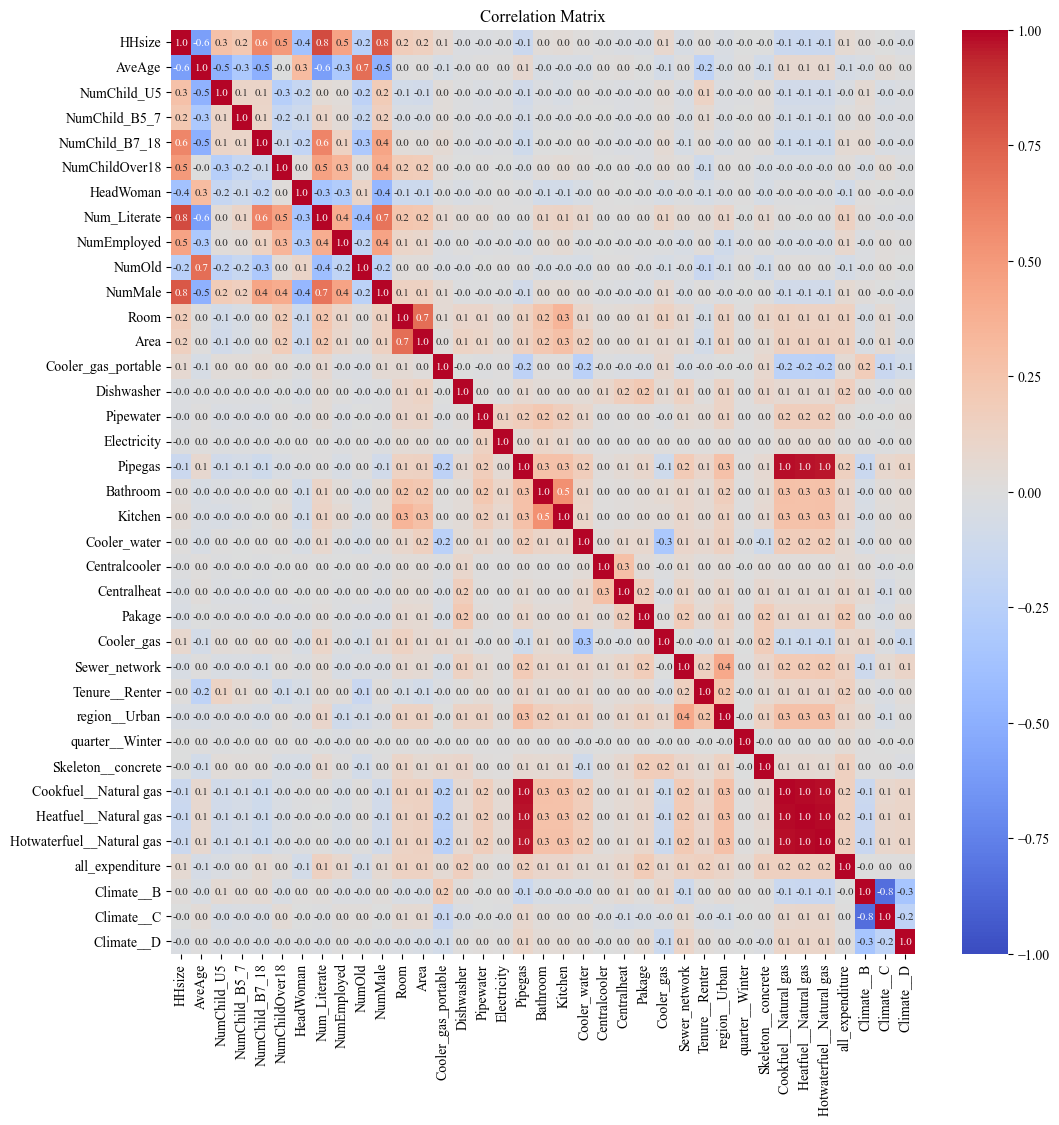

In [58]:
import seaborn as sns
x_vars = [
'HHsize',
'AveAge',
'NumChild_U5',
'NumChild_B5_7',
'NumChild_B7_18',
'NumChildOver18',
'HeadWoman',
'Num_Literate',
'NumEmployed',
'NumOld',
'NumMale',
'Room',
'Area',
'Cooler_gas_portable',
'Dishwasher',
'Pipewater',
'Electricity',
'Pipegas',
'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
'Sewer_network',
'Tenure__Renter',
'region__Urban',
'quarter__Winter',
'Skeleton__concrete',
'Cookfuel__Natural gas',
'Heatfuel__Natural gas',
'Hotwaterfuel__Natural gas',
'all_expenditure',
'Climate__B',
'Climate__C',
'Climate__D'
]
corr_matrix = joindb[x_vars].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

In [70]:
x_vars = [
'HHsize',
#'AveAge',
'NumChild_U5',
'NumChild_B5_7',
#'NumChild_B7_18',
#'NumChildOver18',
'HeadWoman',
#'Num_Literate',
#'NumEmployed',
'NumOld',
#'NumMale',
#'Room',
'Area',
'Cooler_gas_portable',
'Dishwasher',
'Pipewater',
'Electricity',
'Pipegas',
#'Bathroom',
'Kitchen',
'Cooler_water',
'Centralcooler',
'Centralheat',
'Pakage',
'Cooler_gas',
#'Sewer_network',
'Tenure__Renter',
'region__Urban',
'quarter__Winter',
'Skeleton__concrete',
#'Cookfuel__Natural gas',
#'Heatfuel__Natural gas',
#'Hotwaterfuel__Natural gas',
'Climate__B',
#'Climate__C',
#'Climate__D'
]
y_var = 'energy_Ratio'
w_var = 'weight'
df2 = pd.DataFrame()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
for year in joindb["year"].unique():
    df = joindb.loc[joindb["year"]==year]
    X_train, X_test, y_train, y_test ,w_train, w_test = train_test_split(
        df[x_vars], df[y_var], df[w_var],test_size = 0.25, random_state = 1)
    print(f"\n The year {year}")
    print(len(X_train), len(y_train) )
    print(len(X_test), len(y_test) )
    rfr = RandomForestRegressor(n_estimators = 400, random_state = 1, n_jobs=-1, max_depth=5)
    rfr.fit(X_train,y_train, sample_weight=w_train)
    y_pred = rfr.predict(X_test)
    
    
    # --- Evaluation Metrics ---
    mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
    mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred, sample_weight=w_test)
    
    # Print results
    print(f"MAE:  {mae:.3f}")
    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")
    
    impo = pd.Series(rfr.feature_importances_, index=X_train.columns, name=year)
    # Collect into df2
    df2 = pd.concat([df2, impo], axis=1)
    
    


 The year 2010
28627 28627
9543 9543
MAE:  2.517
MSE:  15.901
RMSE: 3.988
R²:   0.115

 The year 2011
28825 28825
9609 9609
MAE:  4.053
MSE:  36.553
RMSE: 6.046
R²:   0.087

 The year 2012
28586 28586
9529 9529
MAE:  3.041
MSE:  24.130
RMSE: 4.912
R²:   0.108

 The year 2013
28680 28680
9561 9561
MAE:  2.467
MSE:  14.547
RMSE: 3.814
R²:   0.146

 The year 2014
28641 28641
9548 9548
MAE:  2.830
MSE:  18.710
RMSE: 4.325
R²:   0.118

 The year 2015
28607 28607
9536 9536
MAE:  2.865
MSE:  19.925
RMSE: 4.464
R²:   0.144

 The year 2016
28516 28516
9506 9506
MAE:  2.989
MSE:  20.943
RMSE: 4.576
R²:   0.149

 The year 2017
28395 28395
9465 9465
MAE:  2.713
MSE:  16.470
RMSE: 4.058
R²:   0.153

 The year 2018
29144 29144
9715 9715
MAE:  2.286
MSE:  12.383
RMSE: 3.519
R²:   0.159

 The year 2019
28647 28647
9549 9549
MAE:  2.169
MSE:  11.815
RMSE: 3.437
R²:   0.146

 The year 2020
28041 28041
9348 9348
MAE:  1.899
MSE:  8.864
RMSE: 2.977
R²:   0.157

 The year 2021
28369 28369
9457 9457
MAE:  

In [71]:
df2.to_pickle("df2.pkl")
#df2 = pd.read_pickle("df2.pkl")

In [72]:
df2= pd.read_pickle("df2.pkl")
df2= df2.reset_index(drop=False)
df2["mean"] = df2.select_dtypes(include="number").mean(axis=1)
df2= df2.sort_values("mean", ascending=False)

In [73]:
df2

,index,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,mean
17,Tenure__Renter,0.215214,0.338626,0.319567,0.326633,0.357655,0.360701,0.351178,0.372843,0.339314,0.396769,0.378350,0.307606,0.326015,0.285611,0.370518,0.336440
0,HHsize,0.095418,0.186176,0.145525,0.146549,0.198694,0.232615,0.258508,0.254855,0.242854,0.250938,0.240113,0.284097,0.208054,0.278430,0.217950,0.216052
10,Pipegas,0.133185,0.029577,0.159242,0.077449,0.011497,0.012496,0.014835,0.020456,0.011802,0.037691,0.166707,0.132937,0.157762,0.125840,0.169442,0.084061
18,region__Urban,0.091562,0.073420,0.028525,0.072908,0.132083,0.097041,0.078575,0.170296,0.109376,0.114582,0.031830,0.031762,0.027152,0.002985,0.010079,0.071478
12,Cooler_water,0.029220,0.056995,0.029110,0.025063,0.056997,0.113692,0.089843,0.059534,0.095801,0.018165,0.053755,0.066112,0.077445,0.090081,0.024383,0.059080
5,Area,0.073284,0.076263,0.059114,0.046319,0.045003,0.024010,0.051904,0.047995,0.071447,0.027286,0.022736,0.061883,0.046584,0.088812,0.059751,0.053493
4,NumOld,0.104582,0.105288,0.081757,0.101533,0.074698,0.037198,0.026380,0.020850,0.067999,0.043249,0.006323,0.012101,0.017108,0.012404,0.002644,0.047608
19,quarter__Winter,0.135900,0.036263,0.065964,0.141486,0.071726,0.070062,0.087558,0.003379,0.000807,0.015361,0.002266,0.006221,0.004844,0.006246,0.003543,0.043442
21,Climate__B,0.003112,0.010294,0.027917,0.013805,0.003267,0.001751,0.001210,0.000910,0.002467,0.002671,0.005571,0.016317,0.018779,0.054206,0.041266,0.013570
3,HeadWoman,0.019663,0.010338,0.020097,0.013250,0.006235,0.029585,0.013644,0.013000,0.005703,0.016070,0.012685,0.003596,0.004907,0.001612,0.012625,0.012201


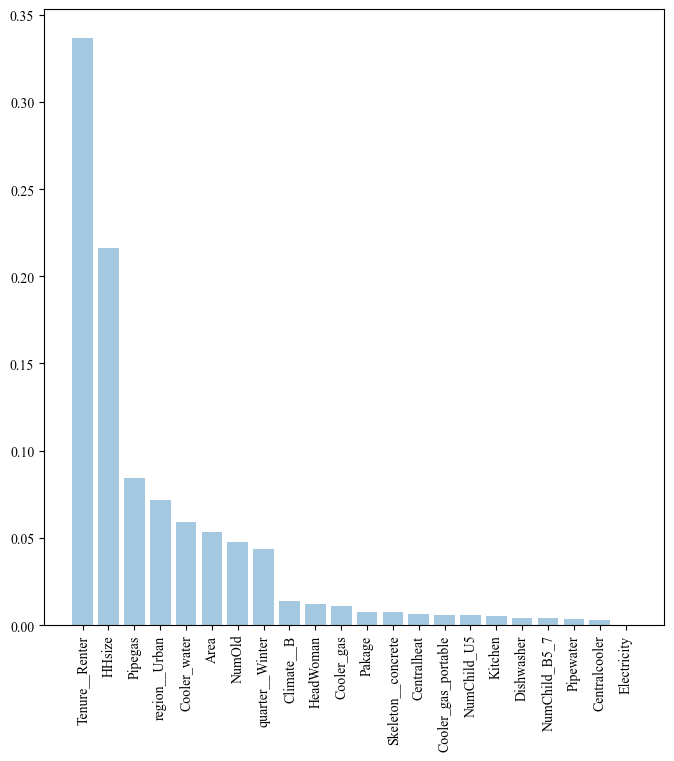

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(df2["index"],df2["mean"], alpha = 0.4)
plt.xticks(rotation = 90)
plt.show()
    

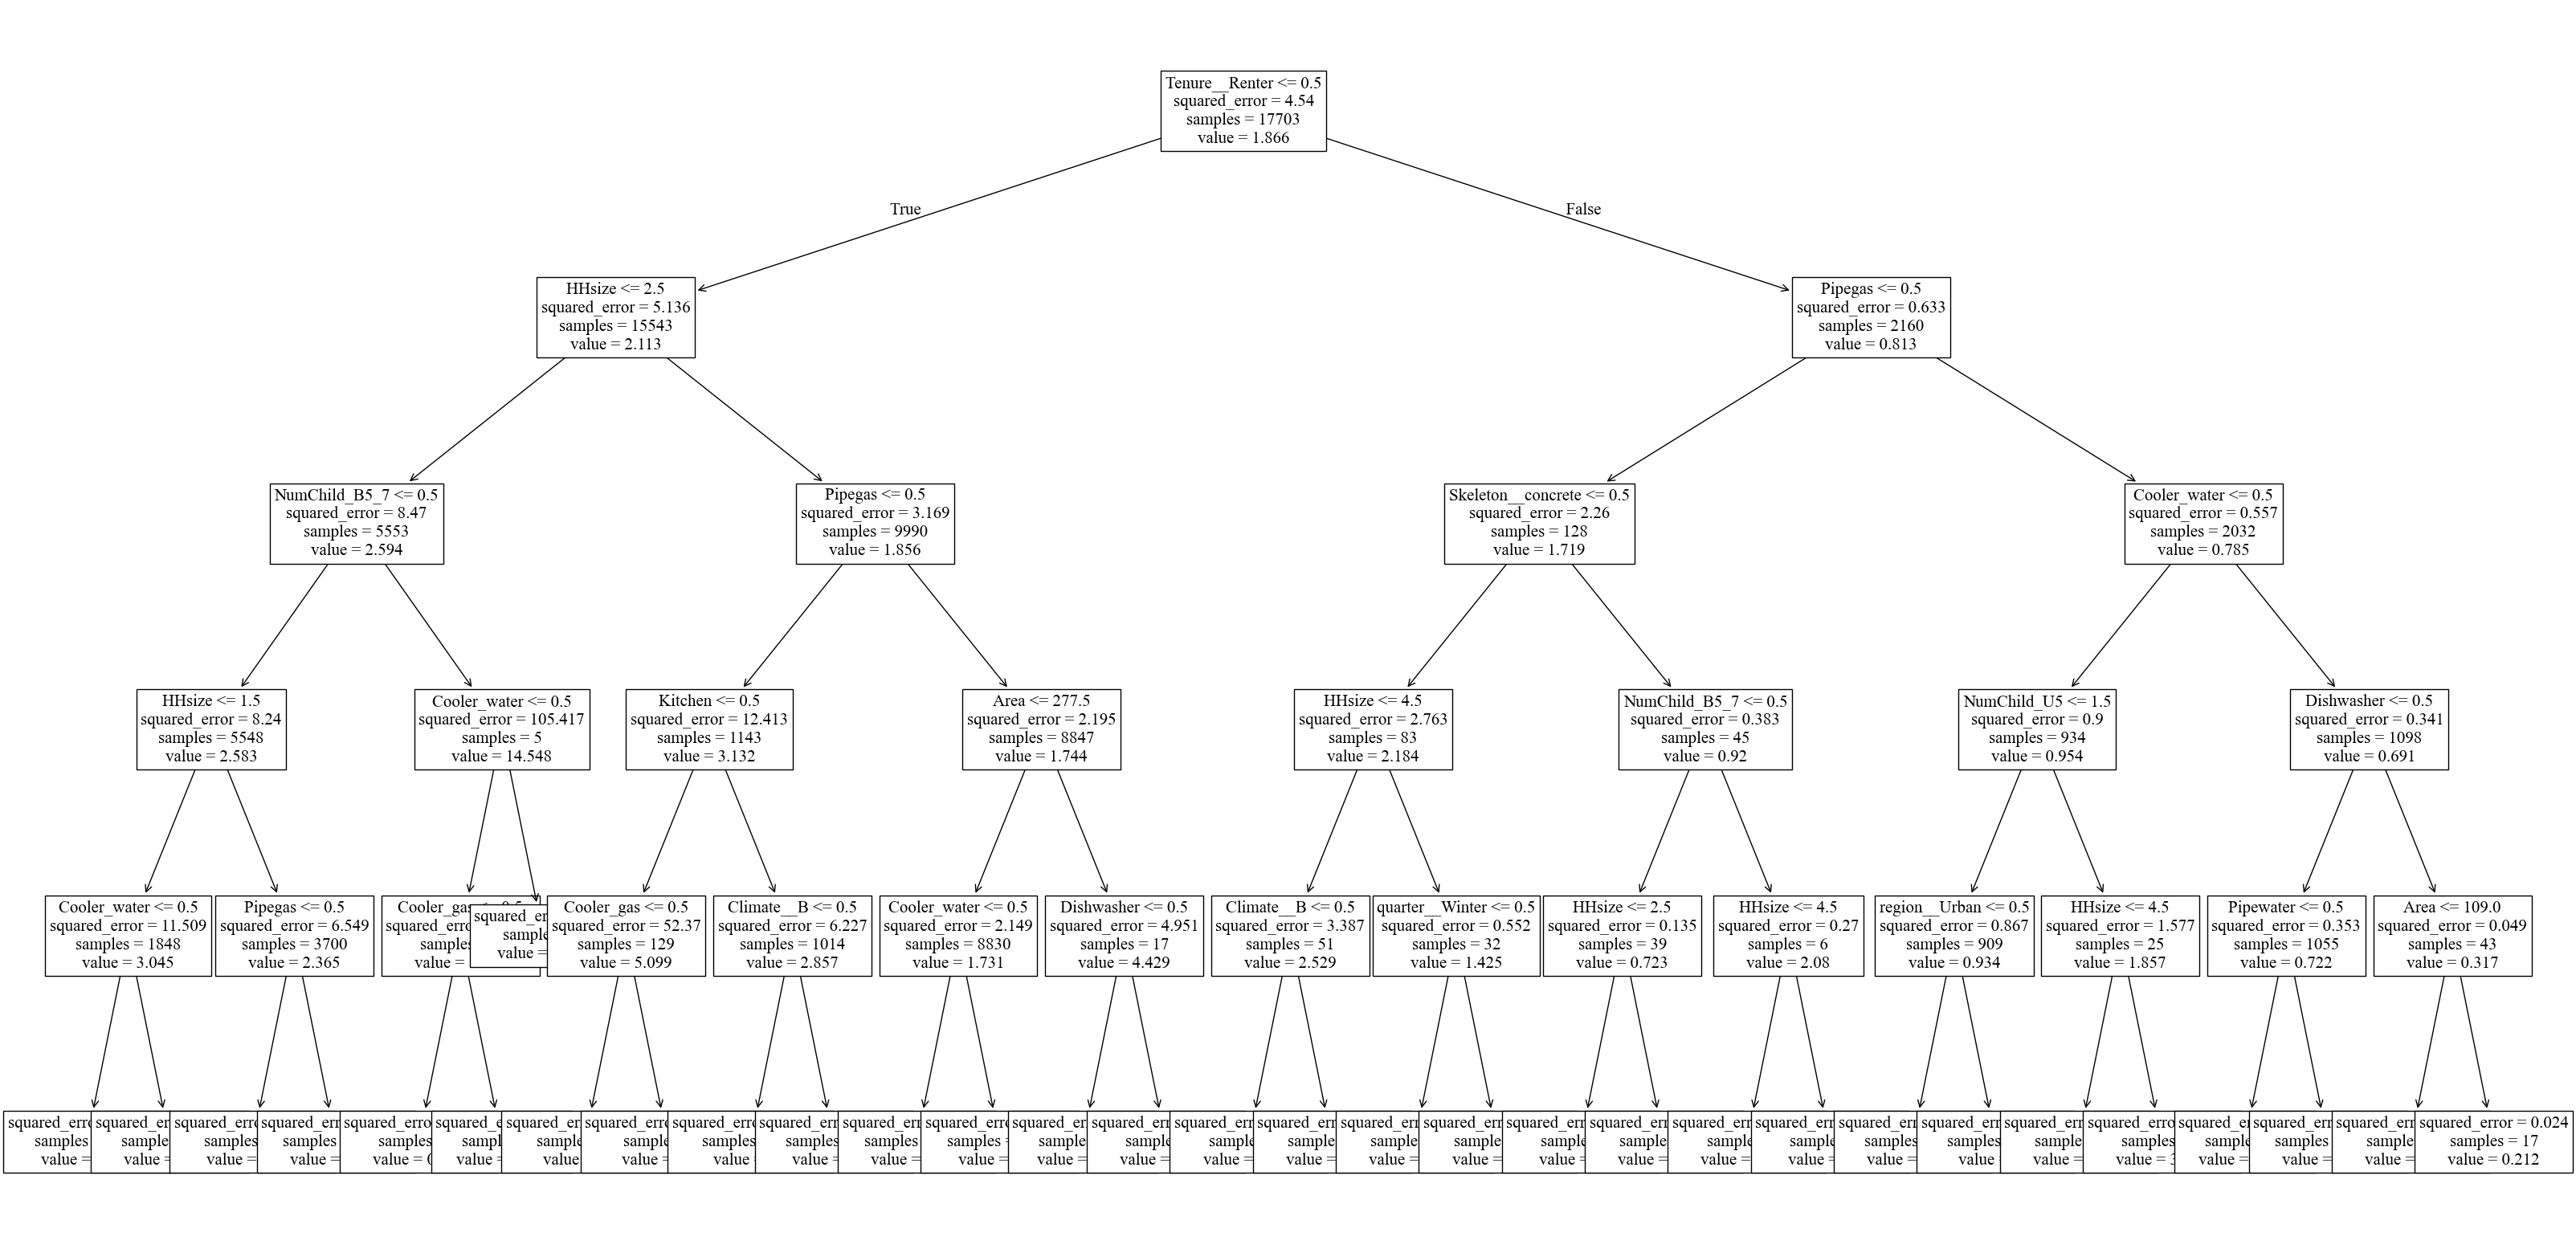

In [69]:
# now we have 100 estimators (trees), so let's pick the first one to visualize
e = rfr.estimators_[0]

from sklearn import tree
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)